# The Battle of Neighborhoods (Code) #

In this notebook we would find the better neighborhood for a person that intends to move to Dublin.

## 1. Data Extraction and Cleaning ##

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd

# Create a dataframe with information about apartment/houses sold in Dublin
df = pd.read_csv("https://www.propertypriceregister.ie/website/npsra/ppr/npsra-ppr.nsf/Downloads/PPR-2020-Dublin.csv/$FILE/PPR-2020-Dublin.csv", encoding="ISO-8859-1")
print(df.shape)
df.head()


(11030, 9)


,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,02/01/2020,"12 WHITECLIFF, WHITECHURCH RD, RATHFARNHAM DUB...",Dublin 16,Dublin,"565,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,02/01/2020,"125 MILL TOWN HALL, MT ST ANNES, MILLTOWN",Dublin 6,Dublin,"588,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
2,02/01/2020,"16 STRATFORD HAVEN, RATHGAR, DUBLIN 6",Dublin 6,Dublin,"232,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,02/01/2020,"20 ST EITHNE ROAD, CABRA, DUBLIN 7",NaN,Dublin,"360,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,02/01/2020,"4 Belarmine View, Belarmine Woods, Stepaside",NaN,Dublin,"555,066.07",No,Yes,New Dwelling house /Apartment,NaN


In [2]:
# Remove properties with prices that were not full market price 
df = df[df['Not Full Market Price'] == 'No']

# Remove not useful columns
df.drop(["Date of Sale (dd/mm/yyyy)","Address","County","Not Full Market Price","VAT Exclusive","Description of Property","Property Size Description"], axis=1, inplace=True)

# Delete rows with no postal code
df.dropna(subset=["Postal Code"], inplace=True)

# Rename column "Price"
df.rename(columns={"Price ()": "Price"}, inplace=True)

# Reset index
df = df.reset_index(drop=True)

# Replace part of each price string to then be converted to a float
df["Price"] = df["Price"].str.replace("\x80", "")
df["Price"] = df["Price"].str.replace(',', '')

# Convert column "Price" to float
df["Price"] = df["Price"].astype(float)


df.head()

,Postal Code,Price
0,Dublin 16,565000.0
1,Dublin 6,588500.0
2,Dublin 6,232500.0
3,Dublin 2,624600.0
4,Dublin 24,208000.0


In [3]:
import numpy as np

# Add crime rates to the dataframe, taking them from The Irish Time magazine and considering
#"Dublin 1","Dublin 3","Dublin 5","Dublin 7","Dublin 9","Dublin 11","Dublin 13","Dublin 15","Dublin 17" as Northside
# and other postal codes as Southside. The crime rate for the Northside is 2571 and for the Southside 1585
df["Crime Rate"] = np.zeros(df.shape[0], dtype=float)
for i in range(df.shape[0]):
    if df.iloc[i,0] in ["Dublin 1","Dublin 3","Dublin 5","Dublin 7","Dublin 9","Dublin 11","Dublin 13","Dublin 15","Dublin 17"]:
        df.iloc[i,2] = 2571
    else:
        df.iloc[i,2] = 1585

df

,Postal Code,Price,Crime Rate
0,Dublin 16,565000.0,1585.0
1,Dublin 6,588500.0,1585.0
2,Dublin 6,232500.0,1585.0
3,Dublin 2,624600.0,1585.0
4,Dublin 24,208000.0,1585.0
...,...,...,...
6852,Dublin 6,765000.0,1585.0
6853,Dublin 18,555066.0,1585.0
6854,Dublin 7,255000.0,2571.0
6855,Dublin 3,325000.0,2571.0


In [4]:
# Group rows by postal code
df = df.groupby("Postal Code").mean()

# Round prices and crime rates using 2 as number of decimals
df["Price"] = round(df["Price"], 2)
df["Crime Rate"] = round(df["Crime Rate"], 2)

# Reset index
df.reset_index("Postal Code", inplace=True)

# Sort rows by their price
df.sort_values("Price", inplace=True)

df

,Postal Code,Price,Crime Rate
1,Dublin 10,224536.12,1585.0
2,Dublin 11,268652.31,2571.0
8,Dublin 17,280778.36,2571.0
12,Dublin 22,281295.44,1585.0
11,Dublin 20,319769.22,1585.0
13,Dublin 24,327107.64,1585.0
3,Dublin 12,341282.83,1585.0
19,Dublin 7,367474.03,2571.0
6,Dublin 15,390048.97,2571.0
16,Dublin 5,399899.22,2571.0


In [5]:
#!pip install geocoder
import geocoder

def get_coordinates(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis("{}, Dublin".format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

# Retrieve Postal Code coordinates   
coords = [get_coordinates(postal_code) for postal_code in df["Postal Code"].tolist()]

# Add columns latitude and longitude
df_coords = pd.DataFrame(coords, columns=["Latitude","Longitude"])
df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,Postal Code,Price,Crime Rate,Latitude,Longitude
1,Dublin 10,224536.12,1585.0,53.388880,-6.298660
2,Dublin 11,268652.31,2571.0,53.397680,-6.208060
8,Dublin 17,280778.36,2571.0,53.372860,-6.362640
12,Dublin 22,281295.44,1585.0,53.283080,-6.296600
11,Dublin 20,319769.22,1585.0,53.358550,-6.241240
13,Dublin 24,327107.64,1585.0,53.302140,-6.307270
3,Dublin 12,341282.83,1585.0,53.347910,-6.396640
19,Dublin 7,367474.03,2571.0,53.337090,-6.286560
6,Dublin 15,390048.97,2571.0,53.331760,-6.294110
16,Dublin 5,399899.22,2571.0,39.812438,-85.206081


In [6]:
#!pip install geopy
from geopy.geocoders import Nominatim

address = "Dublin, Leinster"

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print("The Geograpical Co-ordinate of Dublin, Leinster are {}, {}.".format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Dublin, Leinster are 53.3497645, -6.2602732.


## 2. Extraction of Dublin nearby venues using Foursquare ##

In [7]:
import json, requests

# Establish keys used to query Foursquare API
client_id = "QPT2O4JOXLDJW43COYX2F2N5XS02ATEO5W4POCBNGJ4WPS3Y"
client_secret = "NHZXDY231F3WQ2WRJOMRCM1B34YPFWHGVG454INTLYNX05C5"
version = "20190915"
radius = 700 
limit = 100

In [8]:
def get_nearby_venues(postal_codes, latitudes, longitudes, radius, limit, all_venues=False):
    
    venues_list=[]
    for postal_code, lat, lng in zip(postal_codes, latitudes, longitudes):
        if all_venues:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                client_id, 
                client_secret, 
                version, 
                lat, 
                lng, 
                radius, 
                limit)
        else:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4e4c9077bd41f78e849722f9,4bf58dd8d48988d1fe931735,52f2ab2ebcbc57f1066b8b4f,4bf58dd8d48988d1fd931735,52f2ab2ebcbc57f1066b8b51,4f4531504b9074f6e4fb0102,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,58daa1558bbb0b01f18ec1ca,4bf58dd8d48988d10f951735,4bf58dd8d48988d196941735,4bf58dd8d48988d194941735'.format(
                client_id, 
                client_secret, 
                version, 
                lat, 
                lng, 
                radius, 
                limit)
            
        # Make GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            postal_code, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


# Only some nearby venues of primary services (Bike Rental / Bike Share, Bus Station, Bus Stop, Metro Station, Tram Station,
# Train Station, Grocery Store, Supermarket, Dairy Store, Pharmacy, Hospital and Emergency Room)
dublin_venues = get_nearby_venues(postal_codes=df['Postal Code'],
                                  latitudes=df['Latitude'],
                                  longitudes=df['Longitude'],
                                  radius=radius,
                                  limit=limit
                                 )

# All nearby venues
dublin_all_venues = get_nearby_venues(postal_codes=df['Postal Code'],
                                  latitudes=df['Latitude'],
                                  longitudes=df['Longitude'],
                                  radius=radius,
                                  limit=limit,
                                  all_venues=True
                                 )

In [9]:
print(dublin_venues.shape)
dublin_venues.head()

(315, 7)


,Neighborhood Name,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 10,53.38888,-6.29866,Book A Bus,53.389126,-6.296711,Bus Station
1,Dublin 10,53.38888,-6.29866,Iceland,53.388218,-6.297343,Grocery Store
2,Dublin 10,53.38888,-6.29866,SuperValu,53.390577,-6.298678,Supermarket
3,Dublin 10,53.38888,-6.29866,Dublin Bus Stop No 1525,53.386964,-6.297331,Bus Stop
4,Dublin 10,53.38888,-6.29866,Thurles Station,53.390079,-6.294576,Platform


In [10]:
print(dublin_all_venues.shape)
dublin_all_venues.head()

(603, 7)


,Neighborhood Name,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 10,53.38888,-6.29866,Power city,53.387790,-6.298791,Department Store
1,Dublin 10,53.38888,-6.29866,Iceland,53.388218,-6.297343,Grocery Store
2,Dublin 10,53.38888,-6.29866,Costa Coffee,53.383154,-6.295827,Coffee Shop
3,Dublin 10,53.38888,-6.29866,Molloys Liquor Stores,53.389945,-6.294148,Liquor Store
4,Dublin 10,53.38888,-6.29866,Burger King,53.383866,-6.295180,Fast Food Restaurant


## 3. Preparation of data to perform KMeans ##

In [11]:
# Delete rows with null values and reset the index
dublin_venues.dropna(inplace=True)
dublin_venues.reset_index(inplace=True, drop=True)

print(dublin_venues.shape)
dublin_venues

(315, 7)


,Neighborhood Name,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 10,53.38888,-6.29866,Book A Bus,53.389126,-6.296711,Bus Station
1,Dublin 10,53.38888,-6.29866,Iceland,53.388218,-6.297343,Grocery Store
2,Dublin 10,53.38888,-6.29866,SuperValu,53.390577,-6.298678,Supermarket
3,Dublin 10,53.38888,-6.29866,Dublin Bus Stop No 1525,53.386964,-6.297331,Bus Stop
4,Dublin 10,53.38888,-6.29866,Thurles Station,53.390079,-6.294576,Platform
...,...,...,...,...,...,...,...
310,Dublin 6,53.34814,-6.25740,Bus Stop Nassau St.,53.342536,-6.256197,Bus Line
311,Dublin 6,53.34814,-6.25740,Dublin Bus Stop No 312,53.345576,-6.266227,Bus Line
312,Dublin 6,53.34814,-6.25740,Nassau Street,53.342501,-6.256053,Road
313,Dublin 13,53.35143,-6.37808,Moriarty's SuperValu,53.350316,-6.379498,Supermarket


In [12]:
# Perform One Hot Encoding on venues categories
dublin_venues_onehot = pd.get_dummies(dublin_venues[["Venue Category"]], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
dublin_venues_onehot["Postal Code"] = dublin_venues["Neighborhood Name"] 

dublin_venues_onehot

,Bike Rental / Bike Share,Bike Shop,Bus Line,Bus Station,Bus Stop,Deli / Bodega,Department Store,Food & Drink Shop,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Road,Supermarket,Tram Station,Postal Code
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Dublin 10
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Dublin 10
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Dublin 10
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Dublin 10
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Dublin 10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Dublin 6
311,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Dublin 6
312,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Dublin 6
313,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Dublin 13


In [13]:
# Rename and drop some useless columns
dublin_venues_onehot["Platform"].rename("Train Station",inplace=True)
dublin_venues_onehot.drop(["Bus Line","Bike Shop","Road", "Deli / Bodega", "Food & Drink Shop"], axis=1, inplace=True)

# Group venues by postal code
dublin_venues_onehot = dublin_venues_onehot.groupby("Postal Code").mean()

dublin_venues_onehot

,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
Postal Code,,,,,,,,,,,
Dublin 1,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000
Dublin 10,0.000000,0.111111,0.222222,0.000000,0.111111,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000
Dublin 11,0.000000,0.000000,0.300000,0.000000,0.100000,0.000000,0.000000,0.400000,0.000000,0.200000,0.000000
Dublin 12,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000
Dublin 13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Dublin 14,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000
Dublin 15,0.000000,0.000000,0.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000
Dublin 16,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.142857
Dublin 17,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.166667,0.000000


In [14]:
# Set new index of the initial dataframe as Postal Code
df.set_index("Postal Code",inplace=True)

In [15]:
# Create a copy of the dataframe with the venues
df_test = dublin_venues_onehot.copy()

df_test

,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
Postal Code,,,,,,,,,,,
Dublin 1,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000
Dublin 10,0.000000,0.111111,0.222222,0.000000,0.111111,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000
Dublin 11,0.000000,0.000000,0.300000,0.000000,0.100000,0.000000,0.000000,0.400000,0.000000,0.200000,0.000000
Dublin 12,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000
Dublin 13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Dublin 14,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000
Dublin 15,0.000000,0.000000,0.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000
Dublin 16,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.142857
Dublin 17,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.166667,0.000000


## 4. KMeans ##

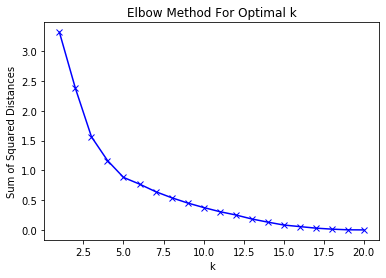

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Find the best number of clusters to use in Kmeans
k = range(1,21)
sum_of_squared_distances = []
for i in k:
    km = KMeans(n_clusters=i)
    km = km.fit(df_test)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(k, sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method For Optimal k")
plt.show()

In [17]:
#To determine the optimal number of clusters, we have to select the value of k at the “elbow”
#ie the point after which the inertia start decreasing in a linear fashion.
#Thus for the given data, we conclude that the optimal number of clusters for the data is 16

num_clusters = 16
kmeans = KMeans(n_clusters=num_clusters)
kmeans = kmeans.fit(df_test)

df_test.insert(0, 'Cluster Labels', kmeans.labels_)

## 5. Map of Dublin Neighborhoods divided into clusters ##

In [18]:
# Add latitude/longitude for each neighborhood
df_test = df_test.join(df.iloc[:,2:4], how="inner", on="Postal Code")

df_test

,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station,Latitude,Longitude
Postal Code,,,,,,,,,,,,,,
Dublin 1,0,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,53.34240,-6.35576
Dublin 10,13,0.000000,0.111111,0.222222,0.000000,0.111111,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,53.38888,-6.29866
Dublin 11,7,0.000000,0.000000,0.300000,0.000000,0.100000,0.000000,0.000000,0.400000,0.000000,0.200000,0.000000,53.39768,-6.20806
Dublin 12,12,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,53.34791,-6.39664
Dublin 13,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,53.35143,-6.37808
Dublin 14,7,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,53.39590,-6.12786
Dublin 15,1,0.000000,0.000000,0.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,53.33176,-6.29411
Dublin 16,3,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.142857,53.35293,-6.28467
Dublin 17,7,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.166667,0.000000,53.37286,-6.36264


In [19]:
#!pip install folium
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Reset the index
df_test.reset_index("Postal Code", inplace=True)

# Create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(num_clusters)
colors_array = cm.rainbow(np.linspace(0, 1, num_clusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, nei, cluster in zip(df_test["Latitude"], 
                                  df_test["Longitude"], 
                                  df_test["Postal Code"], 
                                  df_test["Cluster Labels"]):
    label = folium.Popup(str(nei) + " Cluster " + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6. Clusters exploration ##

In [20]:
all_clusters = df_test.loc[:,df_test.columns[list(range(df_test.shape[1]-2))]]
all_clusters

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
0,Dublin 1,0,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000
1,Dublin 10,13,0.000000,0.111111,0.222222,0.000000,0.111111,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000
2,Dublin 11,7,0.000000,0.000000,0.300000,0.000000,0.100000,0.000000,0.000000,0.400000,0.000000,0.200000,0.000000
3,Dublin 12,12,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000
4,Dublin 13,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
5,Dublin 14,7,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000
6,Dublin 15,1,0.000000,0.000000,0.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000
7,Dublin 16,3,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.142857
8,Dublin 17,7,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.166667,0.000000
9,Dublin 18,10,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000


In [21]:
cluster_0 = df_test.loc[df_test['Cluster Labels'] == 0,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_0

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
0,Dublin 1,0,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.25,0.0,0.25,0.0
20,Dublin 9,0,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.25,0.0,0.25,0.0


In [22]:
cluster_1 = df_test.loc[df_test['Cluster Labels'] == 1,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_1

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
6,Dublin 15,1,0.0,0.0,0.0,0.0,0.500000,0.166667,0.0,0.0,0.0,0.166667,0.0
11,Dublin 20,1,0.0,0.0,0.0,0.0,0.555556,0.000000,0.0,0.0,0.0,0.222222,0.0


In [23]:
cluster_2 = df_test.loc[df_test['Cluster Labels'] == 2,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_2

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
19,Dublin 8,2,0.185185,0.037037,0.333333,0.0,0.074074,0.037037,0.0,0.111111,0.0,0.037037,0.111111


In [24]:
cluster_3 = df_test.loc[df_test['Cluster Labels'] == 3,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_3

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
7,Dublin 16,3,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.142857


In [25]:
cluster_4 = df_test.loc[df_test['Cluster Labels'] == 4,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_4

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
15,Dublin 4,4,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0


In [26]:
cluster_5 = df_test.loc[df_test['Cluster Labels'] == 5,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_5

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
4,Dublin 13,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
cluster_6 = df_test.loc[df_test['Cluster Labels'] == 6,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_6

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
13,Dublin 24,6,0.0,0.0,0.666667,0.0,0.222222,0.0,0.0,0.111111,0.0,0.0,0.0


In [28]:
cluster_7 = df_test.loc[df_test['Cluster Labels'] == 7,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_7

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
2,Dublin 11,7,0.0,0.0,0.300000,0.0,0.1,0.0,0.0,0.400000,0.0,0.200000,0.0
5,Dublin 14,7,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.333333,0.0
8,Dublin 17,7,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.500000,0.0,0.166667,0.0


In [29]:
cluster_8 = df_test.loc[df_test['Cluster Labels'] == 8,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_8

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
12,Dublin 22,8,0.0,0.0,0.5,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0


In [30]:
cluster_9 = df_test.loc[df_test['Cluster Labels'] == 9,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_9

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
14,Dublin 3,9,0.075000,0.000000,0.225000,0.012500,0.187500,0.000000,0.0,0.112500,0.0,0.087500,0.08750
16,Dublin 6,9,0.075269,0.010753,0.236559,0.010753,0.172043,0.010753,0.0,0.064516,0.0,0.096774,0.11828


In [31]:
cluster_10 = df_test.loc[df_test['Cluster Labels'] == 10,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_10

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
9,Dublin 18,10,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0


In [32]:
cluster_11 = df_test.loc[df_test['Cluster Labels'] == 11,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_11

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
10,Dublin 2,11,0.0,0.0,0.25,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
cluster_12 = df_test.loc[df_test['Cluster Labels'] == 12,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_12

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
3,Dublin 12,12,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.25,0.0,0.25,0.0


In [34]:
cluster_13 = df_test.loc[df_test['Cluster Labels'] == 13,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_13

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
1,Dublin 10,13,0.0,0.111111,0.222222,0.0,0.111111,0.0,0.0,0.111111,0.111111,0.222222,0.0


In [35]:
cluster_14 = df_test.loc[df_test['Cluster Labels'] == 14,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_14

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
18,Dublin 7,14,0.076923,0.0,0.076923,0.0,0.230769,0.153846,0.076923,0.0,0.0,0.153846,0.153846


In [36]:
cluster_15 = df_test.loc[df_test['Cluster Labels'] == 15,df_test.columns[list(range(df_test.shape[1]-2))]]
cluster_15

,Postal Code,Cluster Labels,Bike Rental / Bike Share,Bus Station,Bus Stop,Department Store,Grocery Store,Hospital,Hospital Ward,Pharmacy,Platform,Supermarket,Tram Station
17,Dublin 6w,15,0.166667,0.083333,0.166667,0.0,0.083333,0.0,0.0,0.333333,0.0,0.083333,0.0


## 7. Visualization of average prices of apartments/houses and crime rates in Dublin neighborhoods ##

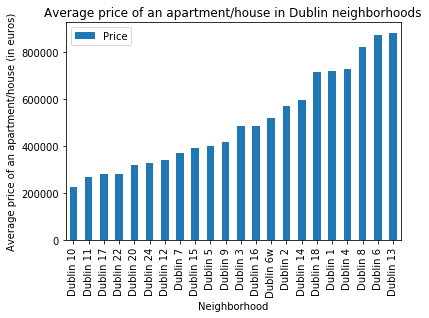

In [37]:
df = df.reset_index().sort_values("Price")

# Show an histogram with the average price of an apartment/house in Dublin neighborhoods (in euros)
df_prices = (df.loc[:,["Postal Code","Price"]]).set_index("Postal Code")
df_prices.plot(kind='bar')
plt.xlabel("Neighborhood")
plt.ylabel("Average price of an apartment/house (in euros)")
plt.title("Average price of an apartment/house in Dublin neighborhoods")
plt.show()

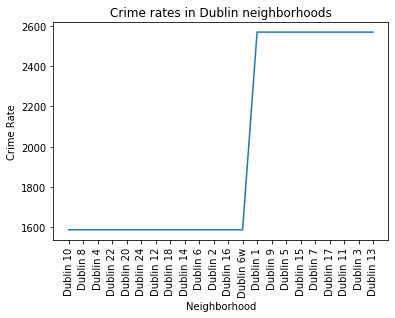

In [38]:
# Show a scatter plot with the crime rates in Dublin neighborhoods
df_crimes=(df.loc[:,["Postal Code","Crime Rate"]]).set_index("Postal Code").sort_values("Crime Rate")
plt.plot(df_crimes)
plt.xlabel("Neighborhood")
plt.ylabel("Crime Rate")
plt.xticks(rotation = 90)
plt.title("Crime rates in Dublin neighborhoods")
plt.show()

## 8. Analyze 5 top venues considering all nearby venues ##

In [39]:
# Group all venues by postal code
dublin_all_venues.groupby("Neighborhood Name").count()

# Perform One Hot Encoding on all venues categories
dublin_all_venues_onehot = pd.get_dummies(dublin_all_venues[["Venue Category"]], prefix="", prefix_sep="")
mid =  dublin_all_venues["Neighborhood Name"]

# Insert Postal Code
dublin_all_venues_onehot.insert(0, "Postal Code", mid)

# Group all venues by postal code and reset index
dublin_all_venues_grouped = dublin_all_venues_onehot.groupby("Postal Code").mean().reset_index()


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 5
indicators = ["st", "nd", "rd"]

# Create columns according to number of top venues
columns = ["Postal Code"]
for ind in np.arange(num_top_venues):
    try:
        columns.append("{}{} Most Common Venue".format(ind+1, indicators[ind]))
    except:
        columns.append("{}th Most Common Venue".format(ind+1))

# Create a new dataframe with the top venues for each Dublin neighborhood
dublin_all_venues_sorted = pd.DataFrame(columns=columns)
dublin_all_venues_sorted["Postal Code"] = dublin_all_venues_grouped["Postal Code"]

for ind in np.arange(dublin_all_venues_grouped.shape[0]):
    dublin_all_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_all_venues_grouped.iloc[ind, :], num_top_venues)

dublin_all_venues_sorted

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Dublin 1,Gym / Fitness Center,Burger Joint,Chinese Restaurant,Farm,Bar
1,Dublin 10,Department Store,Electronics Store,Supermarket,Fast Food Restaurant,Grocery Store
2,Dublin 11,Supermarket,Café,Coffee Shop,Discount Store,Sandwich Place
3,Dublin 12,Mobile Phone Shop,Coffee Shop,Electronics Store,Fast Food Restaurant,Burger Joint
4,Dublin 13,Supermarket,Convenience Store,Gym,Bowling Alley,Shopping Mall
5,Dublin 14,Pub,Convenience Store,Supermarket,Gastropub,Bar
6,Dublin 15,Grocery Store,Pub,Chinese Restaurant,Café,Garden
7,Dublin 16,Supermarket,History Museum,Hotel,Pub,Bistro
8,Dublin 17,Café,Pub,Italian Restaurant,Asian Restaurant,Convenience Store
9,Dublin 18,Supermarket,Grocery Store,Bus Stop,Convenience Store,Pub
